# (9) New distance function

In this notebook we test a new objective function, combining the HD measure as well as the euclidean distance on the trajectories such that our new distance measure is $D_{new} = D_{HD}\times D_{euc}$.

Let's start by importing the SSA and the experimental data (only to be used to given initial volumes, molecule numbers and exponential growth rates) and processing it as was done in notebook 5:

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## First attempt at inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\alpha_0 = 5.0$, $\alpha_1 = 0.3$, $\beta_0 = 1.0$ and $\beta_1 = 0.5$:

In [4]:
true_par = [5.0,0.3,1.0,0.5];

In [5]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_c = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        append!(SSA_data_c, ssa[2]);
    end
    return hcat(SSA_data_c)::Array{Float64,2} # return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [6]:
expt_ssa_conc = Single_lin(lineage_data, true_par, v0_n0_th[1]);

Let's plot this data:

In [7]:
using GpABC, LambertW, Distances, Plots, Distributions, LaTeXStrings, StatsBase, LinearAlgebra; pyplot()

Plots.PyPlotBackend()

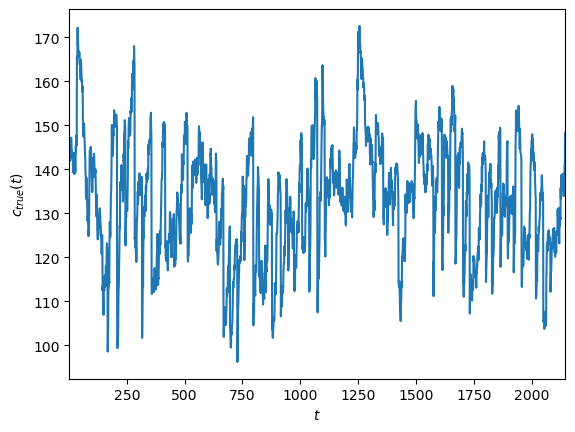

In [8]:
PyPlot.plot(range(1,length(expt_ssa_conc),step=1),expt_ssa_conc[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc)]);

Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.


0.9900000000000002

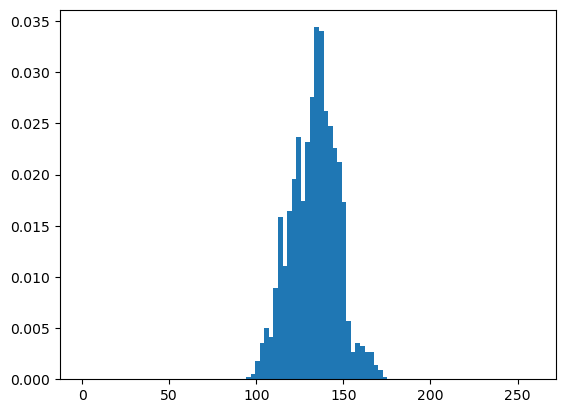

In [9]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0.0, maximum(expt_ssa_conc)*1.5, 100);
true_bin_vals, other_stuff = ax.hist(expt_ssa_conc[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals*(maximum(expt_ssa_conc)*1.5/100))) # check the sum of bins is 1.

true_bin_vals_form = convert(Array{Float64,2},transpose(true_bin_vals));

Now let's set up the tools needed to perform the inference of the parameters as we did in notebook 5. In this case the output will be the bin values for the histogram of the trajectory. Later we will specify the Hellinger distance measure in the SMC-ABC options.

In [10]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    lin_conc = Single_lin(lineage_data, var_params, lin_ic)
    return lin_conc::Array{Float64,2}
end

simulator_function_conc (generic function with 1 method)

Create the new distance function that takes in the sample trajectory vector and experimental trajectory as inputs and outputs the product of the hellinger distance and the euclidean distance between the two trajectories.

In [11]:
function new_distance(samp_traj::Array{Float64,1}, exp_traj::Array{Float64,1})
    euc_dist = euclidean(samp_traj[:], exp_traj[:]); # euclidean distance
    samp_bins = normalize(fit(Histogram, samp_traj[:], mod_bins), mode=:probability).weights;
    exp_bins = normalize(fit(Histogram, exp_traj[:], mod_bins), mode=:probability).weights;
    hell_dist = hellinger(samp_bins, exp_bins); # HD
    
    return euc_dist*hell_dist::Float64 # return the product
end

new_distance (generic function with 1 method)

In [12]:
thres_cutoff = sum(new_distance(simulator_function_conc(true_par)[:], expt_ssa_conc[:]) for i in 1:1000)/1000

65.55960841379462

In [13]:
@time new_distance(simulator_function_conc(true_par)[:], expt_ssa_conc[:])

  0.004412 seconds (17.81 k allocations: 1.697 MiB)


59.56176197023352

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 52/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 91/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 145/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 195/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 248/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 293/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection si

┌ Info: GpABC SMC simulation accepted 339/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 352/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 372/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 386/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 408/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 428/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 437/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 454/25000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 239/30000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 244/31000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 251/32000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 259/33000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 270/34000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 276/35000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 285/36000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 297/37000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 889/42000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 912/43000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 930/44000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 949/45000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 973/46000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 985/47000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 60.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 6/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/c

┌ Info: GpABC SMC simulation accepted 56/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 62/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 72/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 80/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 86/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 91/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 99/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 107/13000 particles.
└ @ GpABC /home/s1402978/.julia/pac

┌ Info: GpABC SMC simulation accepted 74/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 80/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 85/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 87/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 89/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 93/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 95/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 101/25000 particles.
└ @ GpABC /home/s1402978/.julia

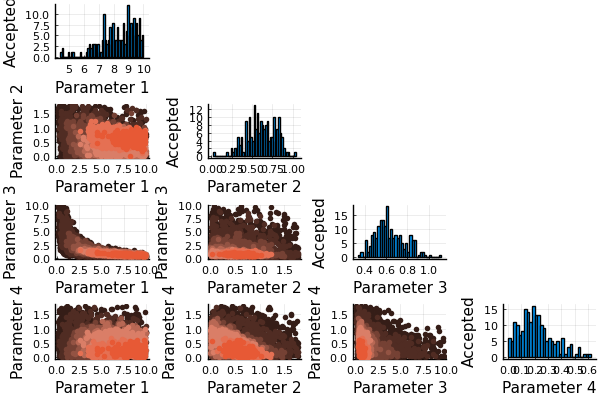

In [14]:
n_particles = 1000;
threshold_schedule = [500.0, 250.0, 100.0, 75.0, 65.0, 60.0, 50.0, 45.0]#, 40.0]#, 37.5, 35.0]#, 350.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(expt_ssa_conc,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

In [15]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 8.501902827933513
 0.6116172317043076
 0.611614151919282
 0.1914082972815629

In [16]:
true_par

4-element Array{Float64,1}:
 5.0
 0.3
 1.0
 0.5

Print the differences.

In [17]:
diff = (pars_conc_1 - true_par)

4-element Array{Float64,1}:
  3.501902827933513
  0.3116172317043076
 -0.38838584808071797
 -0.3085917027184371

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

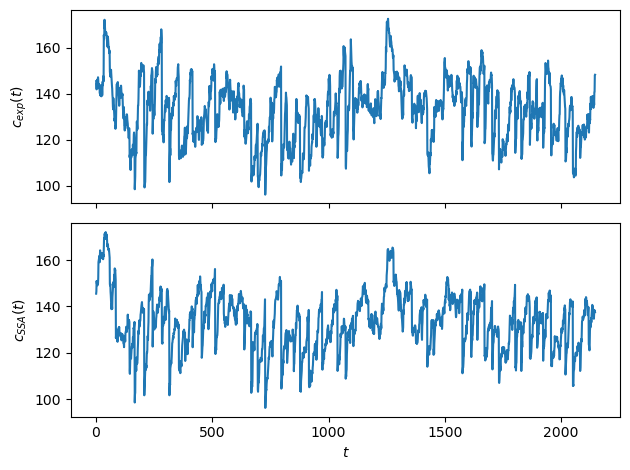

  0.012299 seconds (39.14 k allocations: 3.547 MiB)


In [18]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = single[1:length(single)][:]; expt_c = expt_ssa_conc[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

The inability to infer parameters here seems to arise from the indistinguishability of parameter sets with respect to this objective function of the HD. This is also shown above by the similarity of the behaviour in the concentration trajectories.

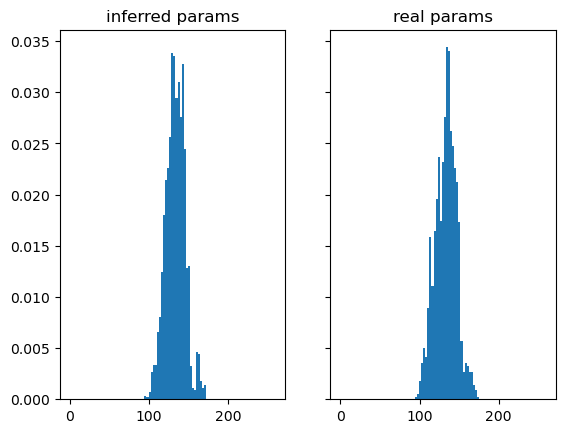

Hellinger distance between these is: 0.10776679136885026

In [19]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_ssa_conc[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

## Second attempt at inference from artificial data

We set $\log_{10}(\alpha_0) = 0.0$, $\alpha_1 = 0.0001$, $\log_{10}(\beta_0) = 0.5$ and $\beta_1 = 1.0$:

In [20]:
true_par_2 = [2.5,0.0001,2.0,1.0];

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [21]:
expt_ssa_conc_2 = Single_lin(lineage_data, true_par_2, v0_n0_th[1]);

Let's plot this data:

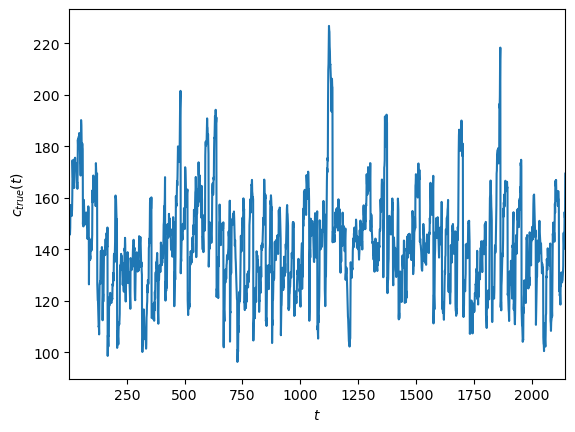

In [22]:
PyPlot.plot(range(1,length(expt_ssa_conc_2),step=1),expt_ssa_conc_2[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc)]);

Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.

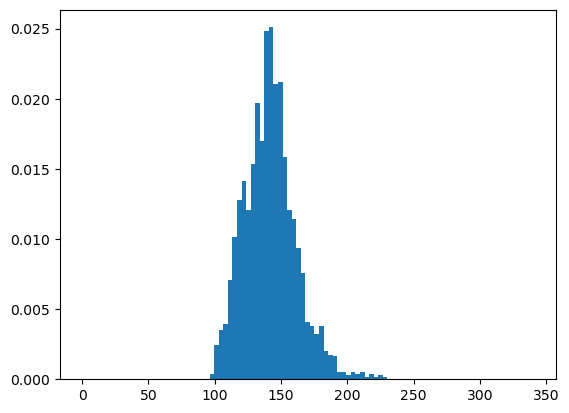


0.9900000000000002

In [23]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0.0, maximum(expt_ssa_conc_2)*1.5, 100);
true_bin_vals_2, other_stuff = ax.hist(expt_ssa_conc_2[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals_2*(maximum(expt_ssa_conc_2)*1.5/100))) # check the sum of bins is 1.

true_bin_vals_form_2 = convert(Array{Float64,2},transpose(true_bin_vals_2));

In [24]:
thres_cutoff = sum(new_distance(simulator_function_conc(true_par_2)[:], expt_ssa_conc_2[:]) for i in 1:1000)/1000

108.54975548444499

In [25]:
@time new_distance(simulator_function_conc(true_par_2)[:], expt_ssa_conc_2[:])

  0.002046 seconds (7.95 k allocations: 813.000 KiB)


106.2644108230685

┌ Info: GpABC rejection simulation. ϵ = 1000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 94/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 193/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 292/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 375/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 480/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 571/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection 

┌ Info: GpABC SMC simulation accepted 90/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 131/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 172/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 216/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 257/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 305/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 337/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 382/9000 particles.
└ @ GpABC /home/s1402978/.julia/p

┌ Info: GpABC SMC simulation accepted 912/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 956/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 998/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 115.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 26/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 56/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 96/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 130/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3w

┌ Info: GpABC SMC simulation accepted 84/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 126/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 174/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 214/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 252/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 287/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 332/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 384/9000 particles.
└ @ GpABC /home/s1402978/.julia/p

┌ Info: GpABC SMC simulation accepted 799/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 843/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 883/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 922/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 966/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 100.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 41/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 73/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/c

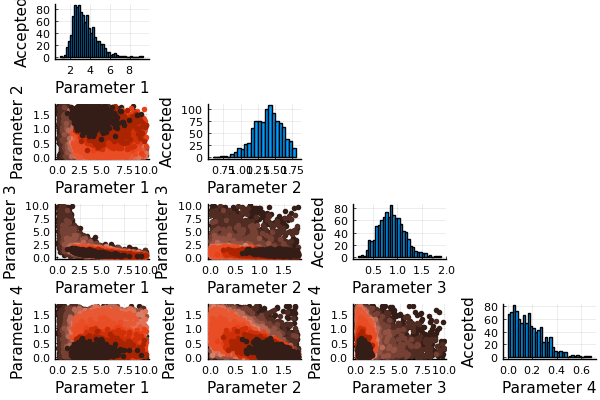

In [26]:
n_particles = 1000;
threshold_schedule_2 = [1000.0, 500.0, 250.0, 175.0, 150.0, 130.0, 120.0, 115.0, 110.0, 107.5, 105.0, 102.5, 100.0]

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(expt_ssa_conc_2,
    simulator_function_conc,
    priors,
    threshold_schedule_2,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors_2=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors = population_colors_2)

Note that if there aren't enough particles in a certain threshold can step back up the thresholds until one is found that had enough accepted particles. Could also consider collecting the final groups of particles in the final thresholds until enough particles are collected.

In [27]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 3.2648918398275364
 1.3998476950526937
 0.8650522455223262
 0.15207796681033453

In [28]:
true_par_2

4-element Array{Float64,1}:
 2.5
 0.0001
 2.0
 1.0

Print the differences.

In [29]:
diff_2 = (pars_conc_2 - true_par_2)

4-element Array{Float64,1}:
  0.7648918398275364
  1.3997476950526937
 -1.1349477544776738
 -0.8479220331896655

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

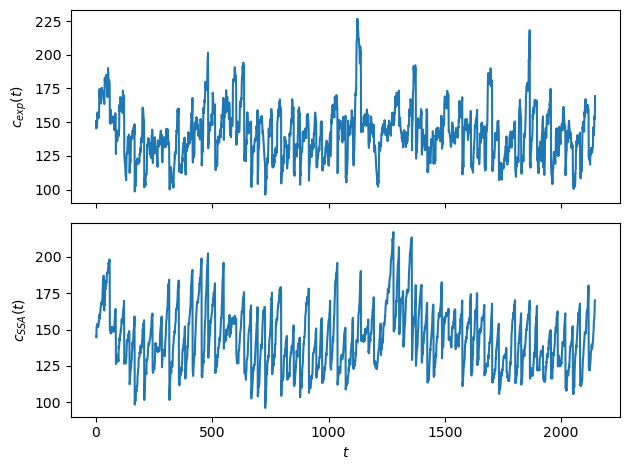

  0.013835 seconds (40.09 k allocations: 3.634 MiB)
82.96069612301795

In [30]:
single_2 = @time Single_lin(num_sep_all_lins[1], pars_conc_2, v0_n0_th[1]); # do for first gen.
concs_ssa_2 = single_2[1:length(single_2)][:]; expt_c_2 = expt_ssa_conc_2[:];
print(new_distance(expt_c_2, concs_ssa_2))


fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c_2),step=1), expt_c_2); axs[2].plot(range(1,length(concs_ssa_2),step=1),concs_ssa_2);

The inability to infer parameters here seems to arise from the indistinguishability of parameter sets with respect to this objective function of the HD. This is also shown above by the similarity of the behaviour in the concentration trajectories.

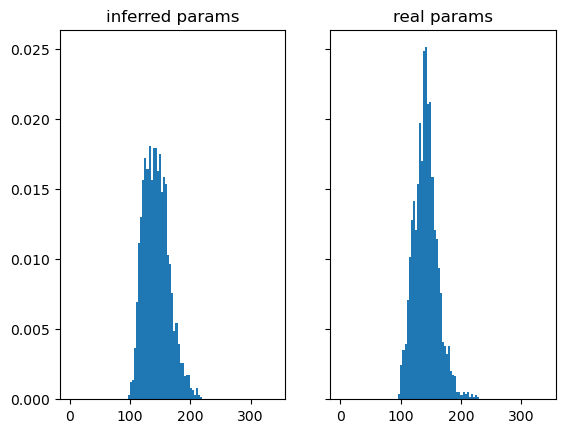

Hellinger distance between these is: 0.103426295189679

In [31]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf_2, other_stuff = ax[1].hist(concs_ssa_2[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals_2, other_stuff = ax[2].hist(expt_ssa_conc_2[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf_2[:],true_bin_vals_2[:])) # print the bin values.

## Inference on Experimental data

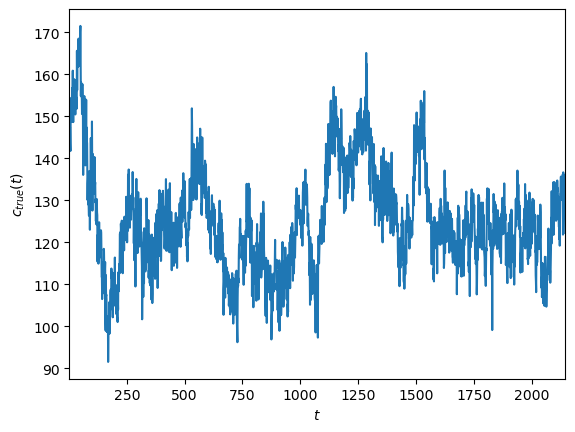

In [32]:
reference_data_exp = hcat(conc_all_lins[1][1:length(single)]); # first lin.
PyPlot.plot(range(1,length(reference_data_exp[:]),step=1),reference_data_exp[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc)]);

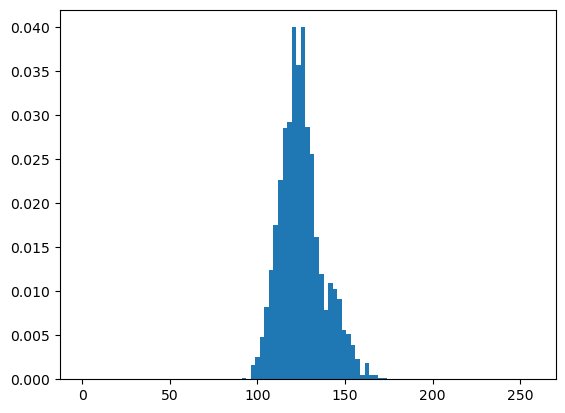


0.9899999999999999

In [33]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0, maximum(reference_data_exp[:])*1.5, 100);
true_bin_vals_exp, other_stuff = ax.hist(reference_data_exp[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals_exp*(maximum(reference_data_exp)*1.5/100))) # check the sum of bins is 1.

true_bin_vals_exp = convert(Array{Float64,2},transpose(true_bin_vals_exp));

┌ Info: GpABC rejection simulation. ϵ = 1000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 98/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 194/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 287/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 382/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 474/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 572/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection 

┌ Info: GpABC SMC simulation accepted 389/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 425/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 461/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 498/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 528/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 553/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 577/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 617/19000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 388/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 420/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 450/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 487/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 523/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 546/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 599/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 624/18000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 580/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 609/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 645/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 667/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 694/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 724/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 754/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 786/26000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 158/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 171/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 183/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 190/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 203/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 218/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 228/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 239/18000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 979/75000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 991/76000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238


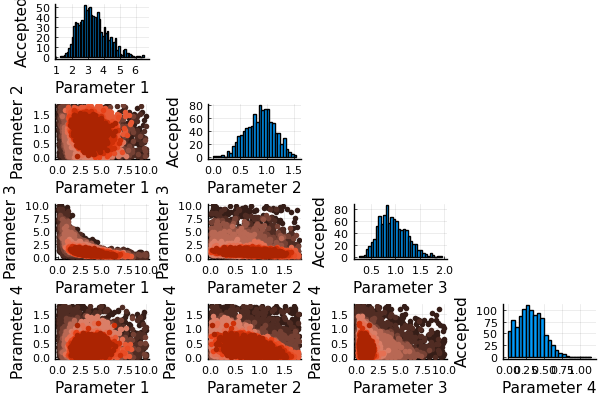

In [34]:
n_particles = 1000;
threshold_schedule_exp = [1000.0, 500.0, 250.0, 150.0, 120.0, 100.0, 90.0, 80.0, 75.0, 70.0, 65.0, 60.0]

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_exp = SimulatedABCSMC(reference_data_exp,
    simulator_function_conc,
    priors,
    threshold_schedule_exp,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,15E4))

# plot the results.
population_colors_exp=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_exp, population_colors=population_colors_exp)

In [35]:
pars_conc_exp = [median(sim_abcsmc_res_conc_exp.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 3.2245055462127414
 0.8921114093227275
 0.9155653637992389
 0.3029761042982108

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

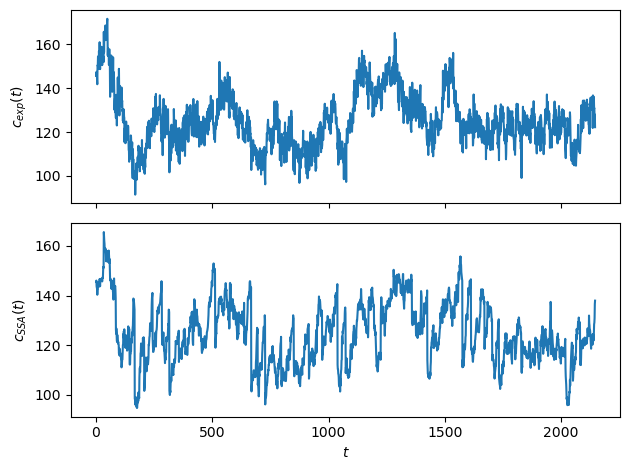

  0.007064 seconds (22.20 k allocations: 1.996 MiB)
60.98704062676548

In [36]:
single_exp = @time Single_lin(num_sep_all_lins[1], pars_conc_exp, v0_n0_th[1]); # do for first gen.
concs_ssa_exp = single_exp[1:length(single_exp)]; expt = reference_data_exp[:];
print(new_distance(expt, concs_ssa_exp))

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt),step=1),expt); axs[2].plot(range(1,length(concs_ssa_exp),step=1),concs_ssa_exp);

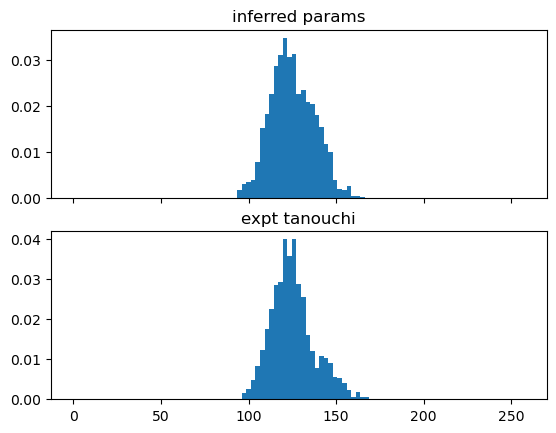

Hellinger distance between these is: 0.11705546611998563

In [37]:
fig, ax = PyPlot.subplots(2, 1, sharex = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_exp[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals_exp, other_stuff = ax[2].hist(reference_data_exp[:], bins = mod_bins, density = true);
ax[2].set_title("expt tanouchi");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals_exp[:])) # print the bin values.


## Do the same inference again twice

┌ Info: GpABC rejection simulation. ϵ = 1000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 92/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 174/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 283/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 404/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 522/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 618/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection 

┌ Info: GpABC SMC simulation accepted 37/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 70/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 96/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 131/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 169/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 205/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 244/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 287/8000 particles.
└ @ GpABC /home/s1402978/.julia/pac

┌ Info: GpABC SMC simulation accepted 604/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 637/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 673/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 703/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 743/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 776/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 809/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 843/24000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 159/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 180/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 201/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 219/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 241/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 251/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 275/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 292/15000 particles.
└ @ GpABC /home/s1402978/.

┌ Info: GpABC SMC simulation accepted 748/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 778/26000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 805/27000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 830/28000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 861/29000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 889/30000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 920/31000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 945/32000 particles.
└ @ GpABC /home/s1402978

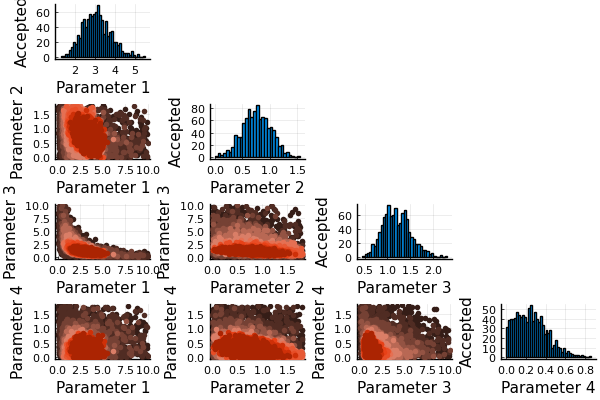

In [38]:
n_particles = 1000;
threshold_schedule_exp = [1000.0, 500.0, 250.0, 150.0, 120.0, 100.0, 90.0, 80.0, 75.0, 70.0, 65.0, 60.0]

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_exp_2 = SimulatedABCSMC(reference_data_exp,
    simulator_function_conc,
    priors,
    threshold_schedule_exp,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,15E4))

# plot the results.
plot(sim_abcsmc_res_conc_exp_2, population_colors=population_colors_exp)

In [39]:
pars_conc_exp_2 = [median(sim_abcsmc_res_conc_exp_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 3.037633800604568
 0.753166160693066
 1.1711583289311407
 0.2401118871990437

┌ Info: GpABC rejection simulation. ϵ = 1000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 133/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 228/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 321/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 415/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 521/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 618/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection

┌ Info: GpABC SMC simulation accepted 337/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 407/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 480/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 543/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 623/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 712/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 794/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 883/11000 particles.
└ @ GpABC /home/s1402978/.juli

┌ Info: GpABC SMC simulation accepted 950/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 990/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 70.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 47/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 103/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 145/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 181/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm

┌ Info: GpABC SMC simulation accepted 443/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 462/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 488/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 522/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 552/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 579/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 607/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 637/21000 particles.
└ @ GpABC /home/s1402978

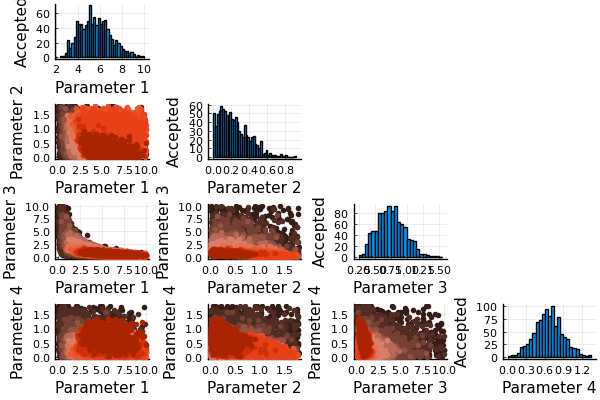

In [40]:
n_particles = 1000;
threshold_schedule_exp = [1000.0, 500.0, 250.0, 150.0, 120.0, 100.0, 90.0, 80.0, 75.0, 70.0, 65.0, 60.0]

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_exp_3 = SimulatedABCSMC(reference_data_exp,
    simulator_function_conc,
    priors,
    threshold_schedule_exp,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,15E4))

# plot the results.
plot(sim_abcsmc_res_conc_exp_3, population_colors=population_colors_exp)

In [41]:
pars_conc_exp_3 = [median(sim_abcsmc_res_conc_exp_3.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 5.476155741646096
 0.2025727055577913
 0.7418849438972297
 0.659423010597213

## Summary of results

The model that we are attempting to infer the parameter for is:
$$\varnothing \xrightarrow{a_1(t)}m\, P\xrightarrow{d}\varnothing,$$
where $a_1(t) = \alpha_0 V(t)^{\alpha_1}$ and $m$ is a random number drawn from a geometric distribution with time-dependent mean burst size $b(t) = \beta_0 V(t)^{\beta_1}$ and degradation rate $d = 0$. The volume of the system grows according to exponential growth law: $V(t) = V_0 e^{\theta t}$. Later on in this sheet we also go onto assess the minimum threshold for the SMC-ABC data. 

Let's see the inferred medians of the posterior distributions in some tables.

In [42]:
using DataFrames;

In [48]:
par_conc = convert(Array{Float64,2},transpose([true_par pars_conc_exp pars_conc_exp_2 pars_conc_exp_3]));
df_conc = DataFrame(alpha_0 = par_conc[:,1], alpha_1 = par_conc[:,2], beta_0 = par_conc[:,3], beta_1 = par_conc[:,4]);

In [49]:
df_conc

,alpha_0,alpha_1,beta_0,beta_1
,Float64,Float64,Float64,Float64
1,5.0,0.3,1.0,0.5
2,3.22451,0.892111,0.915565,0.302976
3,3.03763,0.753166,1.17116,0.240112
4,5.47616,0.202573,0.741885,0.659423
